# Outlier Identification and Removal

Adapted from Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).

## Overview

This tutorial covers the identification and removal of outliers in datasets. We'll explore various techniques to detect and handle outliers, which are data points that significantly differ from other observations in a dataset.

## Learning Objectives

- Understand what outliers are and why they matter in data analysis
- Learn different methods to identify outliers
- Implement outlier removal techniques

## Prerequisites

- Basic understanding of Python programming
- Familiarity with NumPy libraries
- Knowledge of basic statistical concepts (mean, standard deviation, percentiles)


## Get Started

To start, we install required packages, import the necessary libraries.

### Install required packages

In [1]:
# Install necessary Python libraries for data analysis and visualization.
# These libraries are:
#   - matplotlib: for plotting and visualization.
#   - seaborn: for statistical data visualization built on top of matplotlib.
#   - numpy: for numerical operations and array manipulation.
#   - pandas: for data manipulation and analysis using DataFrames.
#   - scikit-learn: for machine learning tasks, including model evaluation and metrics.
%pip install matplotlib seaborn numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Import necessary libraries

In [2]:
# Import the NumPy library for numerical operations, often used for array manipulation and mathematical functions.
import numpy as np
# Import the Pandas library for data manipulation and analysis, particularly for working with DataFrames.
import pandas as pd
# Import the Seaborn library for statistical data visualization, built on top of Matplotlib.
import seaborn as sns
# Import specific functions 'percentile' and 'random' from the NumPy library.
# 'percentile' is used to calculate the nth percentile of data, and 'random' for random number generation.
from numpy import percentile, random
# Import the 'LinearRegression' class from scikit-learn's linear_model module.
# This class is used for linear regression models.
from sklearn.linear_model import LinearRegression
# Import the 'mean_absolute_error' function from scikit-learn's metrics module.
# This function is used to calculate the mean absolute error between predictions and true values.
from sklearn.metrics import mean_absolute_error
# Import the 'train_test_split' function from scikit-learn's model_selection module.
# This function is used to split datasets into training and testing sets.
from sklearn.model_selection import train_test_split
# Import the 'LocalOutlierFactor' class from scikit-learn's neighbors module.
# This class is used for outlier detection using the Local Outlier Factor algorithm.
from sklearn.neighbors import LocalOutlierFactor

## Outlier Identification and Removal

### What are Outliers?

An outlier is an observation that is unlike the other observations. They are rare, distinct, or do
not fit in some way.

We will generally define outliers as samples that are exceptionally far from the
mainstream of the data.

Outliers can have many causes, such as:

- Measurement or input error.
- Data corruption.
- True outlier observation.

There is no precise way to define and identify outliers in general because of the specifics of
each dataset. Instead, you, or a domain expert, must interpret the raw observations and decide
whether a value is an outlier or not.

### Remove outliers using Standard Deviation method

#### Generate a dataset of random observations

mean=50.049 stdv=4.994


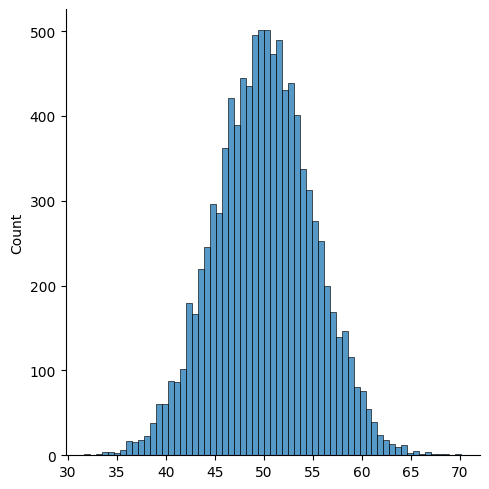

In [3]:
# Seed the random number generator
random.seed(1)

# Generate univariate observations using numpy's randn()
data = 5 * np.random.randn(10000) + 50

# Summarize
print("mean=%.3f stdv=%.3f" % (np.mean(data), np.std(data)))

# Plot the data
sns.displot(data)

#### Calculate summary statistics

In [4]:
# Calculate summary statistics of the 'data' array using NumPy.
# np.mean(data) calculates the arithmetic mean (average) of all elements in the 'data' array.
data_mean = np.mean(data)
# np.std(data) calculates the standard deviation of all elements in the 'data' array.
# Standard deviation measures the dispersion or spread of the data around the mean.
data_std = np.std(data)

#### Identify outliers

In [5]:
# Define the cutoff value for outlier detection, which is 3 standard deviations from the mean.
cut_off = data_std * 3
# Calculate the lower bound for outliers, which is the mean minus the cutoff value.
lower = data_mean - cut_off
# Calculate the upper bound for outliers, which is the mean plus the cutoff value.
upper = data_mean + cut_off

# Initialize an empty list to store the identified outliers.
outliers = []
# Iterate through each data point 'x' in the 'data' list.
for x in data:
    # Check if the data point 'x' is less than the lower bound OR greater than the upper bound.
    if x < lower or x > upper:
        # If the condition is true, it means 'x' is an outlier, so add it to the 'outliers' list.
        outliers.append(x)
# Print the number of outliers identified.
# "%d" is a format specifier for an integer, which will be replaced by the length of the 'outliers' list.
print("Identified outliers: %d" % len(outliers))

Identified outliers: 29


#### Identify non-outliers

In [6]:
# Identify non-outlier observations from the 'data' list.
# This line creates a new list called 'non_outliers' using a list comprehension.
# It iterates through each element 'x' in the 'data' list.
# For each 'x', it checks if 'x' is greater than or equal to 'lower' AND less than or equal to 'upper'.
# If both conditions are true, 'x' is considered a non-outlier and is included in the 'non_outliers' list.
non_outliers = [x for x in data if x >= lower and x <= upper]

# Print the number of non-outlier observations found.
# len(non_outliers) calculates the number of elements in the 'non_outliers' list, which represents the count of non-outlier observations.
# The string "Non-outlier observations: %d" is a format string where %d will be replaced by the integer value of len(non_outliers).
print("Non-outlier observations: %d" % len(non_outliers))

Non-outlier observations: 9971


### Remove outliers using Interquartile Range method

#### Generate a dataset of random observations

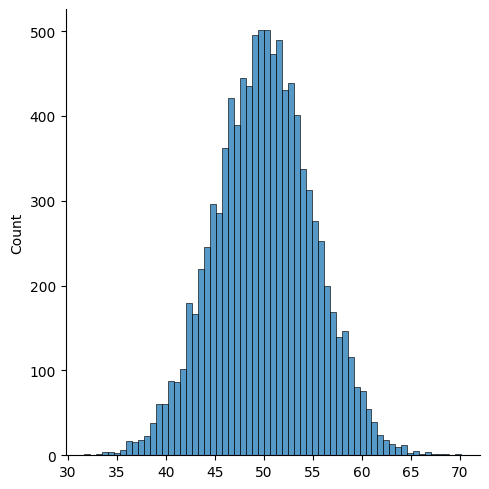

In [7]:
# Seed the random number generator to ensure reproducibility.
# Setting the seed to 1 means that every time this code is run, it will produce the same random numbers, making the results consistent.
random.seed(1)

# Generate univariate observations (10000 data points) from a normal distribution using NumPy.
# np.random.randn(10000) generates 10000 numbers from a standard normal distribution (mean=0, standard deviation=1).
# Multiplying by 5 scales the standard deviation of the distribution to 5.
# Adding 50 shifts the mean of the distribution to 50, centering it around 50 instead of 0.
data = 5 * np.random.randn(10000) + 50

# Plot the distribution of the generated data using seaborn's displot function.
# sns.displot(data) creates a distribution plot, which by default includes a histogram and a kernel density estimate (KDE) of the 'data'. This visualizes the shape and spread of the generated dataset.
sns.displot(data)

#### Calculate summary statistics

In [8]:
# Import the 'percentile' function from the NumPy library.
from numpy import percentile

# Calculate the 25th and 75th percentiles of the 'data' array.
# percentile(data, 25) calculates the 25th percentile (Q1).
# percentile(data, 75) calculates the 75th percentile (Q3).
q25, q75 = percentile(data, 25), percentile(data, 75)
# Calculate the Interquartile Range (IQR).
# IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1).
iqr = q75 - q25
# Print the calculated percentiles and IQR.
# "Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f" is a format string to display the values.
# %.3f formats each percentile and IQR value as a floating-point number with 3 decimal places.
# q25 is the 25th percentile, q75 is the 75th percentile, and iqr is the Interquartile Range.
print("Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f" % (q25, q75, iqr))

Percentiles: 25th=46.685, 75th=53.359, IQR=6.674


#### Identify outliers

In [9]:
# Calculate the Interquartile Range (IQR) which is the difference between the 75th and 25th percentiles (q75 - q25).
iqr = q75 - q25

# Calculate the outlier cutoff range using the IQR method.
# The lower cutoff is calculated as the 25th percentile (q25) minus 1.5 times the IQR.
# The upper cutoff is calculated as the 75th percentile (q75) plus 1.5 times the IQR.
lower, upper = q25 - iqr * 1.5, q75 + iqr * 1.5

# Identify outliers in the 'data' list based on the calculated lower and upper cutoffs.
# This line creates a list called 'outliers' containing all data points 'x' from the 'data' list
# that are either less than the 'lower' cutoff or greater than the 'upper' cutoff.
outliers = [x for x in data if x < lower or x > upper]

# Print the number of outliers identified.
# len(outliers) calculates the number of elements in the 'outliers' list, which represents the count of outliers.
print("Identified outliers: %d" % len(outliers))

Identified outliers: 81


#### Identify non-outliers

In [10]:
# Identify non-outlier observations from the 'data' list.
# This line creates a new list called 'non_outliers' using a list comprehension.
# It iterates through each element 'x' in the 'data' list and checks if it falls within the defined bounds.
non_outliers = [x for x in data if x >= lower and x <= upper]

# Print the number of non-outlier observations identified.
# len(non_outliers) calculates the number of elements in the 'non_outliers' list.
# The print statement outputs a string indicating the count of non-outlier observations.
print("Non-outlier observations: %d" % len(non_outliers))

Non-outlier observations: 9919


### Remove outliers using Automatic Outlier Detection method

A simple approach to identifying outliers is to locate those examples that are far from the
other examples in the multi-dimensional feature space. This can work well for feature spaces
with low dimensionality (few features), although it can become less reliable as the number of
features is increased, referred to as the **curse of dimensionality**. The local outlier factor, or
LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier
detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers
based on the size of its local neighborhood. Those examples with the largest score are more
likely to be outliers.

#### Diabetes Dataset

The dataset classifies patient as
either an onset of diabetes within five years or not. 

```
Number of Instances: 768
Number of Attributes: 8 plus class 
For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
Missing Attribute Values: Yes
Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")
   Class Value  Number of instances
   0            500
   1            268
```

You can learn more about the dataset here:

- Diabetes Dataset File ([pima-indians-diabetes.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv))
- Diabetes Dataset Details ([pima-indians-diabetes.names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names))

#### Summarize diabetes data files

In [11]:
# Load and summarize the dataset
# Define a variable 'pima_indians_diabetes_csv' and assign it the file path to the Pima Indians Diabetes dataset CSV file.
pima_indians_diabetes_csv = "../../Data/pima-indians-diabetes.csv"

# Load the dataset from a CSV file defined by a variable named 'pima_indians_diabetes_csv' into a pandas DataFrame.
# 'header=None' argument indicates that the CSV file does not have a header row.
df = pd.read_csv(pima_indians_diabetes_csv, header=None)

# Retrieve the values from the DataFrame as a NumPy array.
# This converts the pandas DataFrame into a numerical array for further processing.
data = df.values

# Split the dataset into input features (X) and output/target variable (y).
# X is assigned all columns except the last one ([:-1]).
# y is assigned the last column ([-1]), which is assumed to be the target variable.
X, y = data[:, :-1], data[:, -1]

# Summarize the shape of the input features (X) and the output variable (y).
# X.shape will output the dimensions of the input feature matrix (rows, columns).
# y.shape will output the dimensions of the output variable array (rows,).
print(X.shape, y.shape)

(768, 8) (768,)


#### Set up train and test data

In [12]:
# Split the features (X) and target variable (y) into training and testing sets.
# X: Features dataset (presumably a pandas DataFrame or NumPy array).
# y: Target variable dataset (presumably a pandas Series or NumPy array).
# test_size=0.3: Specifies that 30% of the data will be used for the test set, and the remaining 70% for the training set.
# random_state=1: Sets the random seed to 1. This ensures that the data split is reproducible.
#                 If you run the code again with the same random_state, you will get the same split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Print the shapes of the resulting training and testing sets.
# X_train.shape:  Outputs the dimensions (number of rows, number of columns) of the training features dataset.
# X_test.shape:   Outputs the dimensions of the testing features dataset.
# y_train.shape:  Outputs the shape (number of rows) of the training target variable dataset.
# y_test.shape:   Outputs the shape of the testing target variable dataset.
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(537, 8) (231, 8) (537,) (231,)


#### Evaluate module on raw dataset

In [13]:
# Fit the linear regression model to the training data.
# X_train: Training features (independent variables).
# y_train: Training target variable (dependent variable).
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data using the fitted linear regression model.
# X_test: Test features (independent variables) for which predictions are to be made.
yhat = model.predict(X_test)

# Evaluate the model's predictions using Mean Absolute Error (MAE).
# MAE measures the average absolute difference between the predicted values (yhat) and the true values (y_test).
mae = mean_absolute_error(y_test, yhat)

# Print the calculated Mean Absolute Error (MAE), formatted to 3 decimal places.
# "MAE: %.3f" creates a string that includes "MAE: " followed by the MAE value rounded to 3 decimal places.
print("MAE: %.3f" % mae)

MAE: 0.324


#### Remove outliers from the data using Local Outlier Factor (LOF)

Next, we can try removing outliers from the training dataset. The expectation is that the
outliers are causing the linear regression model to learn a bias or skewed understanding of the
problem, and that removing these outliers from the training set will allow a more effective model
to be learned.

The **Local Outlier Factor** (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. 

We can achieve this by defining the **LocalOutlierFactor** model and using it to
make a prediction on the training dataset, marking each row in the training dataset as normal
(1) or an outlier (-1). We will use the default hyperparameters for the outlier detection model,
although it is a good idea to tune the configuration to the specifics of your dataset.



In [14]:
# Initialize the Local Outlier Factor (LOF) model.
# LOF is an unsupervised anomaly detection method that identifies outliers based on their local density deviation.
lof = LocalOutlierFactor()

# Fit the LOF model to the training dataset (X_train) and predict outlier labels.
# fit_predict() method fits the model to X_train and returns labels:
# -1 for outliers and 1 for inliers.
yhat = lof.fit_predict(X_train)

# Create a boolean mask to select inliers (non-outliers) from the training data.
# 'yhat != -1' creates a boolean array where True indicates inliers (label 1) and False indicates outliers (label -1).
mask = yhat != -1

# Use the mask to filter the training data, keeping only the inlier rows.
# X_train[mask, :] selects rows from X_train where mask is True and all columns.
# y_train[mask] selects elements from y_train where mask is True.
X_train, y_train = X_train[mask, :], y_train[mask]

# Print the shape of the updated training dataset after removing outliers.
# This shows the number of rows and columns in X_train and the number of elements in y_train after outlier removal.
print(X_train.shape, y_train.shape)

# Initialize a Linear Regression model.
model = LinearRegression()

# Fit the Linear Regression model to the filtered training data (X_train, y_train) which now excludes outliers.
model.fit(X_train, y_train)

# Use the trained Linear Regression model to make predictions on the test dataset (X_test).
yhat = model.predict(X_test)

# Evaluate the model's predictions by calculating the Mean Absolute Error (MAE).
# mean_absolute_error() computes the average absolute difference between the true values (y_test) and the predicted values (yhat).
mae = mean_absolute_error(y_test, yhat)

# Print the calculated Mean Absolute Error (MAE) formatted to 3 decimal places.
# Lower MAE values indicate better model performance.
print("MAE: %.3f" % mae)

(519, 8) (519,)
MAE: 0.317


We can see MAE (Mean Absolute Error) reduced from to 0.324 to 0.317.

## Conclusion

In this tutorial, we've learned how to identify and remove outliers using various statistical methods. We've seen how outliers can affect data analysis and how their removal can lead to more accurate insights. Always to consider the context of your data when applying outlier removal techniques, as some apparent outliers may contain useful information.

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.